# Emulation running from notebook

In [5]:
# Convenient jupyter setup
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True

## Import some library pieces

In [6]:
import matplotlib.pyplot as plt
from sithom.plot import plot_defaults

plot_defaults()

/Users/simon/new-orleans/env/lib/python3.8/site-packages/xarray/backends/cfgrib_.py:29: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(


In [7]:
# six degrees of freedom search
from src.models.emu6d import SixDOFSearch

 /Users/simon/new-orleans/env/lib/python3.8/site-packages/geopandas/_compat.py:112: UserWarning:The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.


## Run 6D with fake function to generate hold out set

In [8]:
# Two degrees of freedom search [bearing and position]
from src.models.emulation import EmulationSmash

In [9]:
## Let's see if the six degrees of freedom search works
tf  = SixDOFSearch(dryrun=True, path="FakeTest", test_data_path="None", seed=0)
tf.run_initial(samples=1000)
tf.setup_active()
tf.run_active(1)
tf.save_initial_data()
# tf.save_real()


Sweep, dryrun=True: 100%|██████████| 1000/1000 [00:00<00:00, 4790.44it/s]
 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


In [10]:
tf  = SixDOFSearch(dryrun=True, path="Test", test_data_path="FakeTest", seed=0)
tf.load_test_data()

loading data from /Users/simon/new-orleans/data/FakeTest


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/xarray/backends/plugins.py:64: RuntimeWarning:Engine 'cfgrib' loading failed:
Cannot find the ecCodes library


In [11]:
tf.test_x_data

array([[7.23500013e-01, 3.47499996e-01, 2.91500002e-01, 8.53500009e-01,
        8.88499975e-01, 6.23499990e-01],
       [9.40500021e-01, 7.82500029e-01, 5.16499996e-01, 8.81500006e-01,
        6.34500027e-01, 8.56500030e-01],
       [5.45499980e-01, 5.00000024e-04, 3.72500002e-01, 9.54999998e-02,
        7.79500008e-01, 6.50000013e-03],
       ...,
       [2.43499994e-01, 4.90500003e-01, 3.70499998e-01, 2.74500012e-01,
        1.67500004e-01, 3.66499990e-01],
       [5.00000024e-04, 2.00499997e-01, 8.57500017e-01, 1.90500006e-01,
        8.01500022e-01, 8.42499971e-01],
       [3.63003886e-02, 1.45794354e-01, 3.10069501e-01, 9.98625690e-01,
        2.66997147e-02, 9.08617722e-02]])

In [12]:
df = tf.load_real_df(data_path=tf.test_data_path) # ")

### Plot Test Hold out set in 6D with real units

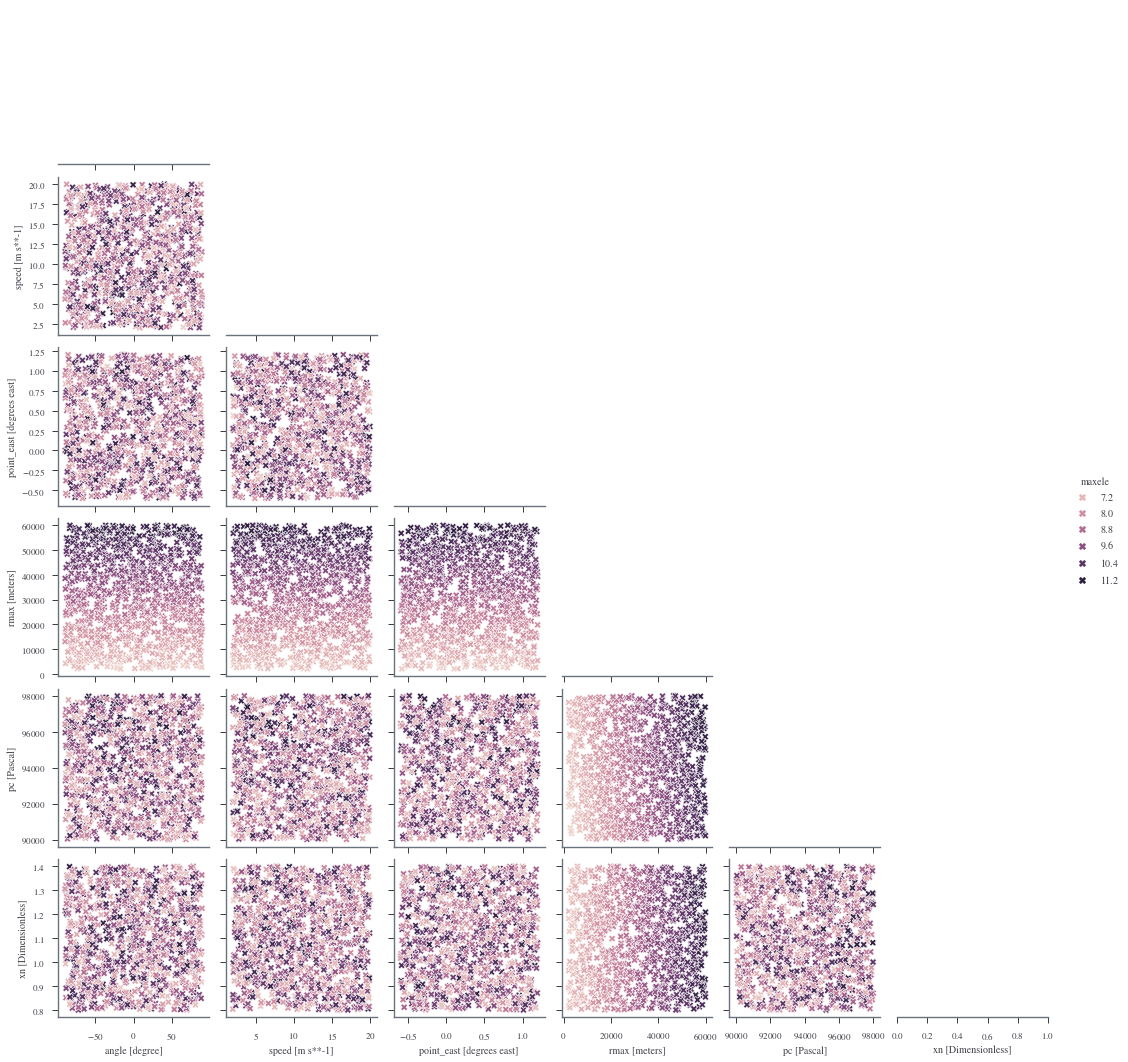

In [13]:
import seaborn as sns
sns.pairplot(df, hue="maxele", corner=True)

In [14]:
tf  = SixDOFSearch(dryrun=True, path="TestHoldout6D", seed=100)
tf.run_initial(samples=1000)
tf.setup_active()
tf.save_initial_data()

Sweep, dryrun=True: 100%|██████████| 1000/1000 [00:00<00:00, 5023.54it/s]
 /Users/simon/new-orleans/env/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/simon/new-orleans/env/lib/python3.8/site-packages/GPy/kern/src/stationary.py:484: RuntimeWarning:overflow encountered in multiply
 /Users/simon/new-orleans/env/lib/python3.8/site-packages/GPy/kern/src/stationary.py:484: RuntimeWarning:invalid value encountered in multiply
 /Users/simon/new-orleans/env/lib/python3.8/site-packages/GPy/kern/src/stationary.py:487: RuntimeWarning:overflow encountered in multiply
 /Users/simon/new-orleans/env/lib/python3.8/site-packages/GPy/kern/src/stationary.py:487: RuntimeWarning:invalid value encountered in multiply


## Implement verification curves: include WandB call?

In [15]:
import wandb

In [16]:
wandb.init(project="6DTest", entity="sdat2")

In [18]:
rf  = SixDOFSearch(dryrun=True, path="Test6DRun",test_data_path="FakeTest", seed=100)
rf.load_test_data()

loading data from /Users/simon/new-orleans/data/FakeTest


In [22]:
print(rf.test_x_data.shape, rf.test_y_data.shape)

(1001, 6) (1001, 1)


In [23]:
rf.run_initial(samples=1000)

Sweep, dryrun=True: 100%|██████████| 1000/1000 [00:00<00:00, 7063.59it/s]
 /Users/simon/new-orleans/env/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/simon/new-orleans/env/lib/python3.8/site-packages/GPy/kern/src/stationary.py:484: RuntimeWarning:overflow encountered in multiply
 /Users/simon/new-orleans/env/lib/python3.8/site-packages/GPy/kern/src/stationary.py:484: RuntimeWarning:invalid value encountered in multiply
 /Users/simon/new-orleans/env/lib/python3.8/site-packages/GPy/kern/src/stationary.py:487: RuntimeWarning:overflow encountered in multiply
 /Users/simon/new-orleans/env/lib/python3.8/site-packages/GPy/kern/src/stationary.py:487: RuntimeWarning:invalid value encountered in multiply


In [24]:
rf.setup_active()

In [26]:
mean, var = rf.model_gpy.predict(rf.test_x_data)

In [28]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [29]:
print("RMSE: ", mean_squared_error(rf.test_y_data, mean, squared=False))
print("MAE: ", mean_absolute_error(rf.test_y_data, mean))
print("R2: ", r2_score(rf.test_y_data, mean))

RMSE:  0.00031514491130127875
MAE:  0.0002276602493205273
R2:  0.9999999319508119


In [31]:
rf.test_metrics()

rmse 0.00031514491130127875 mae 0.0002276602493205273 r2 0.9999999319508119


In [32]:
rf.run_active(1)
rf.test_metrics()

 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00031460675814411556 mae 0.00022680456663985344 r2 0.9999999321830201


In [33]:
for i in range(100):
    rf.run_active(1)
    rf.test_metrics()

 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00031371170530918144 mae 0.00022594271761249048 r2 0.9999999325683484


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003132812788811135 mae 0.0002258583195858345 r2 0.9999999327532599


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003132978207409398 mae 0.00022589242253856002 r2 0.9999999327461582


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00031325097882917976 mae 0.00022585472263188925 r2 0.9999999327662672


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00031264155962645494 mae 0.0002253808021456987 r2 0.9999999330276147


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003126693676229735 mae 0.00022526527624438904 r2 0.9999999330157004


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003126346714644967 mae 0.0002253325096308636 r2 0.9999999330305658


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00031244834483667663 mae 0.00022500630563510032 r2 0.999999933110368


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00031245111641200937 mae 0.00022530190610084728 r2 0.9999999331091812


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00031237890471288326 mae 0.0002251670007240924 r2 0.9999999331400965


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003125761530255714 mae 0.0002253422928528732 r2 0.9999999330556338


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003125271696926259 mae 0.00022522560320940773 r2 0.9999999330766137


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003116446035104897 mae 0.00022467323953295255 r2 0.9999999334540588


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00031162574684214157 mae 0.00022469365565599622 r2 0.9999999334621115


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.000311740886050666 mae 0.00022455910048567465 r2 0.9999999334129337


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003112802261117854 mae 0.00022421638916573602 r2 0.99999993360958


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00031134815519864184 mae 0.0002242495254676719 r2 0.9999999335806007


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00031137051810272467 mae 0.0002242055348301931 r2 0.9999999335710591


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00031127225361391673 mae 0.00022398802322438964 r2 0.9999999336129807


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00031113073932428247 mae 0.00022392812277699465 r2 0.9999999336733303


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003111313001030689 mae 0.00022397761912723607 r2 0.9999999336730911


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003105672758012411 mae 0.00022338484237549615 r2 0.9999999339133504


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.000311017232645093 mae 0.0002239329339230727 r2 0.999999933721716


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003112148756603171 mae 0.0002240691720622355 r2 0.9999999336374531


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003111086569912325 mae 0.00022394634141870544 r2 0.9999999336827449


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003103134246521625 mae 0.00022322353932109645 r2 0.9999999340213419


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003101996737548481 mae 0.0002231072154755883 r2 0.9999999340697043


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003102882363503794 mae 0.00022306306019835332 r2 0.9999999340320525


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00031012552909296423 mae 0.00022295057595958187 r2 0.9999999341012181


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003102418484327766 mae 0.00022318608367662122 r2 0.9999999340517753


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003101046427381454 mae 0.00022322199102715895 r2 0.9999999341100941


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003101084139986567 mae 0.000223233700485229 r2 0.9999999341084915


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003101612153187569 mae 0.00022324166197444623 r2 0.9999999340860514


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00031014069395634083 mae 0.00022326024314343152 r2 0.9999999340947733


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003102436353242831 mae 0.00022330559708011149 r2 0.9999999340510156


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00030987947295067796 mae 0.00022330406518438235 r2 0.999999934205746


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003092267709163122 mae 0.0002229652005903253 r2 0.9999999344826201


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003091523970197567 mae 0.00022306221491967 r2 0.9999999345141323


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00030917506213940226 mae 0.00022300785907423406 r2 0.99999993450453


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.000308741168064014 mae 0.00022263112603362997 r2 0.9999999346882327


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00030851723503152437 mae 0.00022239333970742602 r2 0.9999999347829408


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003084907952297175 mae 0.00022229972585645637 r2 0.9999999347941185


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003084065726167688 mae 0.0002221449221505881 r2 0.999999934829718


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00030844397732399174 mae 0.0002221841988550086 r2 0.9999999348139089


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003084249189932156 mae 0.00022218310472624545 r2 0.9999999348219641


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00030815719209835647 mae 0.00022185764108806138 r2 0.99999993493507


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003081594654104312 mae 0.00022181299760629312 r2 0.9999999349341101


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003081589207217213 mae 0.0002218831984141062 r2 0.99999993493434


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003081000778372291 mae 0.00022187878721687164 r2 0.9999999349591863


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003078667635149213 mae 0.00022163981850906823 r2 0.9999999350576556


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003081581596873648 mae 0.00022230658441053003 r2 0.9999999349346614


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00030792958763591977 mae 0.00022189890888632958 r2 0.9999999350311483


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00030789941033911955 mae 0.0002218585607355972 r2 0.9999999350438816


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003079036059473475 mae 0.000221845094945798 r2 0.9999999350421114


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.000307994477158779 mae 0.0002218705008480928 r2 0.9999999350037638


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00030793323278688605 mae 0.00022183153842425207 r2 0.9999999350296102


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003079567948866083 mae 0.00022187053596035353 r2 0.9999999350196671


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00030775578164143625 mae 0.00022235811216975986 r2 0.9999999351044688


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00030766468772909776 mae 0.0002217913937577475 r2 0.9999999351428805


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00030786014117990676 mae 0.00022194295969773132 r2 0.9999999350604495


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00030755907964674417 mae 0.00022173879693763478 r2 0.9999999351873983


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003074791737364625 mae 0.00022186137836077404 r2 0.9999999352210714


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003065874521207528 mae 0.00022137006409860905 r2 0.9999999355962579


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003066030692413022 mae 0.00022152378009732222 r2 0.9999999355896964


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003065807605230269 mae 0.00022154633120890794 r2 0.9999999355990692


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003065942364469639 mae 0.0002216612888249697 r2 0.9999999355934075


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.000306064814430493 mae 0.00022136361298847256 r2 0.999999935815648


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003061900895579773 mae 0.0002215763926715693 r2 0.9999999357630948


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003058907866174063 mae 0.00022123311414593035 r2 0.9999999358886175


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003057651206868452 mae 0.00022092401815615643 r2 0.999999935941283


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00030579854291181466 mae 0.00022101255149606616 r2 0.9999999359272781


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00030579046254213015 mae 0.0002208833896942119 r2 0.9999999359306642


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003057773486522565 mae 0.00022089655474359334 r2 0.9999999359361593


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00030571357640714515 mae 0.00022098707787839028 r2 0.9999999359628786


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00030550611725724464 mae 0.00022080922640008375 r2 0.999999936049761


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003159742641325327 mae 0.0002360736407481309 r2 0.9999999315921766


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003134536229763615 mae 0.0002304021787041931 r2 0.9999999326792512


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00033764535087635247 mae 0.0002468851991556649 r2 0.9999999218868956


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00031260676529194087 mae 0.0002275649814560055 r2 0.9999999330425208


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00031073959546854864 mae 0.00022697904210845264 r2 0.9999999338399931


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.000311053176058354 mae 0.00022592803710383581 r2 0.999999933706396


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00031341790525218726 mae 0.00023126072662526932 r2 0.9999999326945926


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003192740644793615 mae 0.00023120844558260009 r2 0.999999930155915


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00030937527101057555 mae 0.0002266334125379005 r2 0.9999999344196782


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00031220962169654063 mae 0.00023051454988318613 r2 0.9999999332125417


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00031077481277457626 mae 0.00022738790390253616 r2 0.9999999338249959


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00031341043274462596 mae 0.00023064032591087517 r2 0.999999932697802


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003132501082748034 mae 0.00022675755962737448 r2 0.9999999327666409


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003089594626179059 mae 0.00022571912195174619 r2 0.999999934595843


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003117482647842048 mae 0.00022616085215404374 r2 0.9999999334097815


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003107170137271823 mae 0.00022775251821894227 r2 0.9999999338496085


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00031496684811001876 mae 0.00022756708926728166 r2 0.9999999320276884


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003116836955984656 mae 0.00022536670879014386 r2 0.9999999334373629


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003104832829976104 mae 0.00022584873729776148 r2 0.9999999339490917


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00031271546907710575 mae 0.00023531706445244406 r2 0.999999932995946


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003147644611463771 mae 0.0002356546557707772 r2 0.9999999321150138


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003089797780556134 mae 0.0002259797299463201 r2 0.9999999345872416


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003072371370087325 mae 0.00022492577845169558 r2 0.9999999353230146


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.000309340761818991 mae 0.00022818206122178286 r2 0.9999999344343077


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003080615128988008 mae 0.000224665523553936 r2 0.9999999349754676


In [34]:
for i in range(300):
    rf.run_active(1)
    rf.test_metrics()

 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003073711378847136 mae 0.00022224149229364978 r2 0.9999999352665848


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00031251708444196384 mae 0.0002267676666904282 r2 0.9999999330809328


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00030948655751987736 mae 0.00022665866600180129 r2 0.9999999343724895


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00030940129487917316 mae 0.000226936918484543 r2 0.9999999344086448


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00030668642445441 mae 0.00022714457623782282 r2 0.9999999355546696


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003092414250597079 mae 0.00022816133055121783 r2 0.9999999344764103


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003072321538712146 mae 0.00022402213082890925 r2 0.9999999353251127


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003089594907862155 mae 0.00022425975179426086 r2 0.9999999345958311


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.000309970804773272 mae 0.0002302495797137121 r2 0.9999999341669568


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00031020286159852097 mae 0.00023019908983841445 r2 0.9999999340683492


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003092630094134224 mae 0.00022512520463773851 r2 0.9999999344672632


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003090208216047289 mae 0.00022621117688665087 r2 0.999999934569862


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003208864712358599 mae 0.0002333992845628195 r2 0.9999999294486765


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003090966611458641 mae 0.00022785542011407854 r2 0.9999999345377425


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003071293649657173 mae 0.00022811331494956619 r2 0.9999999353683812


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00030763017716440655 mae 0.00022372824327679072 r2 0.9999999351574297


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00030409148653571746 mae 0.0002220768663120752 r2 0.9999999366406266


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003069846624948557 mae 0.00022524049932040312 r2 0.9999999354292686


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00030700273474314617 mae 0.00022616247873871202 r2 0.9999999354216658


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003075454788317579 mae 0.0002247472162211479 r2 0.9999999351931304


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003133986498871655 mae 0.00022724973068593597 r2 0.9999999327028624


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00030769837237800107 mae 0.00022255728259326188 r2 0.999999935128678


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003068284913850014 mae 0.00022372605381769473 r2 0.9999999354949495


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003080234501670206 mae 0.00022660745432387844 r2 0.9999999349915348


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00030927521057340916 mae 0.00022355160946139997 r2 0.9999999344620922


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00031090993122699124 mae 0.00022639736051766036 r2 0.9999999337674403


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003057063603363026 mae 0.00022475832484119103 r2 0.9999999359659016


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003048444825838598 mae 0.00022324632285548778 r2 0.9999999363264552


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00030928582430532665 mae 0.00022417572553819922 r2 0.9999999344575939


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00030446128158168203 mae 0.00022376180475155153 r2 0.9999999364864347


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00030613473140082495 mae 0.0002235374460934146 r2 0.9999999357863203


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003062229711263803 mae 0.00022276179469199613 r2 0.9999999357492972


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003080509382662317 mae 0.00022728233725143068 r2 0.9999999349799316


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00031020259365238765 mae 0.0002293673900969494 r2 0.9999999340684631


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003061529229977138 mae 0.0002238659121236466 r2 0.9999999357786885


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003192405378482751 mae 0.00024308439986216637 r2 0.9999999301705828


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003056080768462571 mae 0.00022497693862326814 r2 0.9999999360070685


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.000306877419894837 mae 0.00022642638870894405 r2 0.9999999354743753


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00030859718795650304 mae 0.00022854305554425488 r2 0.9999999347491342


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00030884349572294853 mae 0.00022672751965845163 r2 0.9999999346449323


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.000311342907066328 mae 0.0002308909232343283 r2 0.9999999335828398


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00031179283548480723 mae 0.00022706547746477956 r2 0.9999999333907393


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003058550619053535 mae 0.00022368633289197512 r2 0.9999999359035916


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00030746836228586556 mae 0.00022487008962344325 r2 0.9999999352256268


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00030739643947887987 mae 0.00022309021697919606 r2 0.9999999352559272


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003043577869936103 mae 0.00022192051816522822 r2 0.9999999365296073


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003032938646336207 mae 0.00021992203292838512 r2 0.9999999369725698


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00030481190757885885 mae 0.00022590160544759902 r2 0.9999999363400625


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003037996807781378 mae 0.0002227132261294431 r2 0.9999999367621674


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003040752797988496 mae 0.0002201261424295699 r2 0.99999993664738


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003163348652062216 mae 0.00023223465846784514 r2 0.9999999314359486


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003011729355412782 mae 0.0002198504553981237 r2 0.9999999378509873


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00030260659346343423 mae 0.000222364227735012 r2 0.9999999372578895


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003008601522238778 mae 0.00021564599196216322 r2 0.99999993798001


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00029970153667831375 mae 0.00021833706215259073 r2 0.9999999384567695


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00030326241488549184 mae 0.00022360454473617427 r2 0.9999999369856403


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00030338399997424377 mae 0.0002243196589693066 r2 0.9999999369351023


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0002986233098903985 mae 0.00021575188362850422 r2 0.9999999388987971


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00029829742942325167 mae 0.000217840302760409 r2 0.999999939032081


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0002996438858769557 mae 0.00021846444839263617 r2 0.9999999384804442


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00030475255246548865 mae 0.00022624124681274756 r2 0.9999999363648527


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00029880356625262155 mae 0.00021799386105853275 r2 0.9999999388250106


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00030068972377632385 mae 0.00021823172418334368 r2 0.9999999380502551


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0002995089546773006 mae 0.00021828319594882997 r2 0.9999999385358369


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003033505689524011 mae 0.0002243983403001554 r2 0.9999999369490001


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003060600250517104 mae 0.0002215822678739616 r2 0.9999999358176567


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00030044534646083684 mae 0.00022118393490900778 r2 0.99999993815091


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00030012158652220123 mae 0.00021771664581435028 r2 0.9999999382841355


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00029912402417774136 mae 0.00021810186220042057 r2 0.9999999386937235


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003008250098195197 mae 0.00022451184518205777 r2 0.9999999379944978


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003012138870810715 mae 0.0002199349997942053 r2 0.9999999378340848


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003059102438557849 mae 0.00022849530997849608 r2 0.9999999358804611


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0002976869139980487 mae 0.00021820240916367142 r2 0.9999999392813876


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00029897341324469417 mae 0.00021677431348297705 r2 0.9999999387554441


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00029841584053661775 mae 0.00021798181785894077 r2 0.9999999389836681


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003003441686459581 mae 0.00021777366144767044 r2 0.9999999381925596


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0002988807108780241 mae 0.00021517150304341135 r2 0.9999999387934183


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00029697427836235436 mae 0.00021476418638999593 r2 0.9999999395717494


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00030119843265602513 mae 0.00022325822852000906 r2 0.9999999378404638


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003008000009534774 mae 0.00021780248156674269 r2 0.9999999380048069


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00029628673176608966 mae 0.00021618305669776297 r2 0.9999999398512291


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003074527343840903 mae 0.0002305365692554253 r2 0.9999999352322113


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0002980252663392445 mae 0.00021604211198959861 r2 0.999999939143283


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003039586270085514 mae 0.00022026082747874352 r2 0.9999999366959788


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00030338221910397817 mae 0.00021849162965644977 r2 0.9999999369358425


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00030020676366514774 mae 0.00021648003171063985 r2 0.9999999382490995


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003005167170608852 mae 0.00021761800653289439 r2 0.9999999381215222


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003094578990572239 mae 0.00022976266422789307 r2 0.9999999343846431


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00030042238800297475 mae 0.00022128781757900596 r2 0.9999999381603621


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0002994860758909042 mae 0.00021613489959032412 r2 0.9999999385452267


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003006568554035701 mae 0.00021695487565748567 r2 0.9999999380637978


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0002992579646732048 mae 0.000216801079157977 r2 0.9999999386388082


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00029712971437022203 mae 0.0002138511247265049 r2 0.9999999395084767


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00030424198007413493 mae 0.00022627931864446695 r2 0.9999999365778985


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003012291621562146 mae 0.0002230244378045791 r2 0.9999999378277796


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00030335967858314915 mae 0.00022427807881893617 r2 0.9999999369452133


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003047302941721193 mae 0.00022126493467551295 r2 0.9999999363741479


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00030335586557606704 mae 0.0002190685259209082 r2 0.9999999369467983


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0002953667919736726 mae 0.00021484391195902188 r2 0.9999999402241607


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00030132218859041274 mae 0.00021707705545487394 r2 0.9999999377893732


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003050506411559904 mae 0.00022084915196618927 r2 0.9999999362403045


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0002949626579423556 mae 0.00021446974701260041 r2 0.9999999403876247


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0002980467762528757 mae 0.00021663710312239622 r2 0.9999999391344981


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0002973301337499372 mae 0.00021744831770845516 r2 0.999999939426844


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00029757087124695087 mae 0.00021679764350381468 r2 0.9999999393287164


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00029774970345346983 mae 0.00021903278859804407 r2 0.9999999392557708


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.000294833597486435 mae 0.00021351971172931607 r2 0.99999994043978


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00029527538604536056 mae 0.0002133933969220211 r2 0.9999999402611521


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0002959131457920416 mae 0.00021326501390705067 r2 0.9999999400028159


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0002958545835917003 mae 0.00021326335798939482 r2 0.9999999400265608


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0002939743498429273 mae 0.00021450746900020124 r2 0.9999999407864325


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003135461632858772 mae 0.00023706075065643074 r2 0.9999999326394954


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00029881991166707075 mae 0.00021558169472454006 r2 0.9999999388183175


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0002966295322775595 mae 0.0002148700963942897 r2 0.9999999397119657


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0002956319897423078 mae 0.00021426578044353222 r2 0.999999940116772


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00029658312689613645 mae 0.0002154743822253198 r2 0.9999999397308273


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003003381762122682 mae 0.00021691971300704353 r2 0.999999938195026


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00029870186813650427 mae 0.0002144969287349288 r2 0.9999999388666454


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0002959050826324215 mae 0.0002130027420924216 r2 0.9999999400060855


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003023664962374263 mae 0.00022105760613931738 r2 0.999999937357413


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0002983236042263144 mae 0.0002161798375624865 r2 0.999999939021381


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00029399980680537146 mae 0.00021443053069873847 r2 0.9999999407761767


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0002942566637051082 mae 0.0002153560964121897 r2 0.9999999406726482


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0002952523808662697 mae 0.0002128974443750798 r2 0.9999999402704605


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0002981933223608516 mae 0.0002179178340003635 r2 0.9999999390746297


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00030206358682104123 mae 0.0002186533539379227 r2 0.9999999374828602


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0002957584413375954 mae 0.00021280226124876665 r2 0.9999999400655329


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00029616089286697226 mae 0.00021438920027388303 r2 0.9999999399023111


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0002956887802367491 mae 0.00021287553313994738 r2 0.9999999400937628


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00029744833179300417 mae 0.00021388827510234834 r2 0.9999999393786749


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00029350912333599713 mae 0.00021225868214474515 r2 0.9999999409737


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00029084206423686635 mae 0.00020970983827673728 r2 0.9999999420415467


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003002945400090401 mae 0.00021743078870926837 r2 0.9999999382129839


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00029543912266333065 mae 0.000214542323900434 r2 0.9999999401948808


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0002986735676734653 mae 0.0002161453786931266 r2 0.999999938878229


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.000296393238529554 mae 0.0002161567302495838 r2 0.9999999398079777


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003055757872497792 mae 0.00022871858493775168 r2 0.9999999360205903


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0002950154854966595 mae 0.00021349814249764417 r2 0.9999999403662698


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00029691988014160124 mae 0.00021485734027046192 r2 0.9999999395938852


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00029708078063861996 mae 0.0002175515264416744 r2 0.9999999395283995


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00029312448827942847 mae 0.00021320140748592464 r2 0.9999999411283031


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0002939111418934708 mae 0.00021351254703894462 r2 0.999999940811893


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0002947244951900099 mae 0.00021363979957660003 r2 0.999999940483852


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003060112162093219 mae 0.0002226268002436376 r2 0.999999935838126


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0002951752626081798 mae 0.00021453704152948886 r2 0.9999999403016584


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0002946890423640245 mae 0.00021374808660443303 r2 0.9999999404981696


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00029745603694065245 mae 0.00021786880269861772 r2 0.9999999393755342


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0002917203487283276 mae 0.00021216737646319664 r2 0.9999999416909725


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.000292483636504721 mae 0.00021282152735399508 r2 0.9999999413854416


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00029781595956564845 mae 0.0002168645444158581 r2 0.9999999392287339


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00029325685693647457 mae 0.00021520020087355536 r2 0.9999999410751207


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0002941377566475206 mae 0.00021311046333243662 r2 0.9999999407205861


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00029632038481260906 mae 0.0002124187407809979 r2 0.9999999398375646


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003020349262289166 mae 0.00021883902602391295 r2 0.9999999374947233


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.000293201242253463 mae 0.00021311159137990667 r2 0.9999999410974683


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00029288226894368943 mae 0.00021361240961270821 r2 0.9999999412255586


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0002942387374021425 mae 0.00021287810613533986 r2 0.9999999406798765


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00029545327603967445 mae 0.00021734508389485547 r2 0.9999999401891506


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0002983019059193068 mae 0.00021519225076145824 r2 0.9999999390302511


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0002916978086069131 mae 0.00021208766407288226 r2 0.9999999416999827


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00029155873030393 mae 0.00021137603368487972 r2 0.9999999417555632


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00029309381795466734 mae 0.0002145996567957351 r2 0.9999999411406223


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0002899702013768333 mae 0.00020774225140388145 r2 0.9999999423885123


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0002927757898737103 mae 0.00021153651964539528 r2 0.9999999412682863


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003022786575211367 mae 0.00022590073154080283 r2 0.9999999373938036


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00030289414585025543 mae 0.00021949961136876964 r2 0.9999999371385913


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0002940766562263938 mae 0.0002155255071506418 r2 0.9999999407452114


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0002916034438425806 mae 0.00021036379650228644 r2 0.999999941737697


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00029274773381169706 mae 0.00021145952091006172 r2 0.9999999412795421


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0002921809745270663 mae 0.00021150871810003016 r2 0.9999999415066875


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003055159179697269 mae 0.00023114549938329466 r2 0.999999936045658


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00029532525015773517 mae 0.00021648562570290714 r2 0.9999999402409739


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00029071472098104306 mae 0.0002134372064308596 r2 0.999999942092289


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0002896790990069083 mae 0.00020977919813559043 r2 0.999999942504127


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00029918121748360993 mae 0.00022237245897548265 r2 0.9999999386702774


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00029077344308204846 mae 0.0002119273484595219 r2 0.9999999420688929


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0002877874656096416 mae 0.00020683772036004651 r2 0.9999999432525829


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0002923421582665768 mae 0.00021311250173425514 r2 0.9999999414421331


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0002884212466378195 mae 0.00021043004344245133 r2 0.9999999430023632


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0002918330826705563 mae 0.00021527536903971859 r2 0.9999999416458973


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0002953826484796275 mae 0.00021223013056948637 r2 0.9999999402177425


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00030023320737869013 mae 0.0002177209485002861 r2 0.9999999382382203


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00028821626898039096 mae 0.00020922532181611163 r2 0.9999999430833496


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0002905419892486394 mae 0.00021250812282117012 r2 0.9999999421610818


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0002930911225647135 mae 0.00021075448714793897 r2 0.9999999411417048


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00028973445911547745 mae 0.0002094283914982355 r2 0.9999999424821491


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.000291180740218537 mae 0.00021001600872815507 r2 0.9999999419064868


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0002871563044689601 mae 0.00020840296435188364 r2 0.9999999435012211


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00029250045368955815 mae 0.0002151108195619503 r2 0.999999941378701


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0002966197047690721 mae 0.00021436269179342314 r2 0.9999999397159604


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00028877941505339814 mae 0.00020929908566567936 r2 0.9999999428607133


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00029342486759983895 mae 0.00021089308901068294 r2 0.9999999410075837


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00028951084815253674 mae 0.0002098723088832925 r2 0.999999942570897


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00028883991637720734 mae 0.0002101636460554492 r2 0.9999999428367686


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0002881282199127556 mae 0.00020899778088736073 r2 0.9999999431181199


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00029040760035294836 mae 0.00020920553539651728 r2 0.9999999422145757


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0002958481908290618 mae 0.0002141264337658861 r2 0.9999999400291526


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00028867204313241834 mae 0.00020956686239688343 r2 0.9999999429031956


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00029581945664042454 mae 0.00021934307506719122 r2 0.9999999400408013


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00029275523104118484 mae 0.00021558479616532968 r2 0.9999999412765344


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0002883632427918684 mae 0.00020878933536504964 r2 0.9999999430252863


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0002915733010416328 mae 0.0002145073837454294 r2 0.9999999417497414


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00029103356513869 mae 0.0002096081603350471 r2 0.9999999419651977


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00029122772777049775 mae 0.00021418015443917096 r2 0.9999999418877362


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0002928930981506231 mae 0.00021160499195051007 r2 0.9999999412212122


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0002955782274102809 mae 0.00021814153823936148 r2 0.9999999401385502


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00029315949588882667 mae 0.000216651980794348 r2 0.9999999411142403


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003019256050840001 mae 0.00022615032369420642 r2 0.9999999375399625


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0002913914262379461 mae 0.00021096880152895978 r2 0.9999999418223884


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00029319805391838386 mae 0.00021728014920420355 r2 0.9999999410987492


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00028798156231494594 mae 0.00020959765247795714 r2 0.999999943176011


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0002948194676877834 mae 0.00021619907921692434 r2 0.9999999404454887


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00029146830214916595 mae 0.0002153136710588751 r2 0.999999941791687


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00029007668300906527 mae 0.0002089578969409872 r2 0.9999999423461928


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00028899523751548466 mae 0.00020851602542690332 r2 0.999999942775274


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00029340097144089764 mae 0.00021152716170786727 r2 0.9999999410171919


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00029507713893267286 mae 0.0002139939729294066 r2 0.9999999403413423


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00028577234780133445 mae 0.0002078178146876767 r2 0.9999999440445032


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00028664387967127164 mae 0.00020806579420325148 r2 0.9999999437026832


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0002850375615681318 mae 0.00020591151517403868 r2 0.9999999443318821


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0002867755722962559 mae 0.00020971049846122599 r2 0.999999943650942


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00028689550621626434 mae 0.00020873111659232494 r2 0.9999999436038001


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00028970526952395195 mae 0.00021412074120044387 r2 0.9999999424937379


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0002881534848922618 mae 0.00021018823673916206 r2 0.9999999431081439


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00030056351874562 mae 0.00022660545133140704 r2 0.9999999381022471


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0002871779799626692 mae 0.000207715956171133 r2 0.9999999434926914


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00028529807683178883 mae 0.00020559653986126228 r2 0.9999999442300779


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00029669632117550003 mae 0.0002212448840106438 r2 0.9999999396848138


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00029349795652396907 mae 0.00021283021315126024 r2 0.9999999409781913


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00028672805164247977 mae 0.00020832023476364208 r2 0.9999999436696153


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00029425704035810827 mae 0.00021749420878762322 r2 0.9999999406724963


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00030079628887785234 mae 0.00022909923742348077 r2 0.999999938006337


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0002990987378503218 mae 0.00022680316316270454 r2 0.999999938704088


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00029194416328563234 mae 0.00021681436116772722 r2 0.9999999416014661


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00028760828284712193 mae 0.00021166562910287406 r2 0.9999999433232253


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0002940946711386459 mae 0.00021367130711426893 r2 0.9999999407379513


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0002855807917814178 mae 0.0002075531157730703 r2 0.9999999441194931


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.000289242418816691 mae 0.000208742047612174 r2 0.999999942677342


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0002895571711529736 mae 0.00020901372150937704 r2 0.9999999425525177


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00028751327892940755 mae 0.00020835635244873167 r2 0.9999999433606624


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0002949940385486057 mae 0.00021455584712039996 r2 0.99999994037494


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00028498844065745537 mae 0.00020540047674448477 r2 0.9999999443510672


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0002880384181711147 mae 0.00021336236299770054 r2 0.9999999431535714


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0002924509130203958 mae 0.0002185534330561225 r2 0.9999999413985566


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0002885201212554667 mae 0.0002111041836804529 r2 0.9999999429632774


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00028265071105572256 mae 0.00020742658444936326 r2 0.9999999452602871


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00030109048454682704 mae 0.00022046608477348568 r2 0.9999999378850112


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0002900334168137845 mae 0.00020989184924721154 r2 0.9999999423633902


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00028746738057477294 mae 0.00020757521576449982 r2 0.9999999433787448


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0002912308556009036 mae 0.0002172817877455812 r2 0.999999941886488


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0002872054537790126 mae 0.000207985958574689 r2 0.9999999434818789


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0002921345233150074 mae 0.0002159941929150534 r2 0.9999999415252846


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0002847554824264533 mae 0.0002070597220980135 r2 0.9999999444420082


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00028434629908187715 mae 0.0002047551166323257 r2 0.9999999446015632


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0002858242516863302 mae 0.00020644948448087354 r2 0.9999999440241754


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0002901910778680312 mae 0.00020924576776328694 r2 0.999999942300711


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0002857515331278977 mae 0.00020593186482749707 r2 0.9999999440526541


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0002845788326051397 mae 0.00020687458817288378 r2 0.9999999445109183


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00028632750559788106 mae 0.00020849086517623808 r2 0.9999999438268873


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0002929234540419046 mae 0.00021586281093212875 r2 0.9999999412090277


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00028978927567286153 mae 0.00021351395220901837 r2 0.9999999424603827


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0002854285507590483 mae 0.00021001498027794653 r2 0.9999999441790562


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0002871937518063393 mae 0.00020529834598632937 r2 0.9999999434864845


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00029690730170626333 mae 0.00022054741778777074 r2 0.9999999395990031


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00028597347637727164 mae 0.0002094797809771127 r2 0.9999999439657118


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0002840527674838397 mae 0.0002063583945517227 r2 0.9999999447158802


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00028393289511914545 mae 0.00020444977382977486 r2 0.999999944762531


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00028869762820440015 mae 0.0002114201462202008 r2 0.9999999428930741


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0002929098285351042 mae 0.00021732902814516135 r2 0.9999999412144969


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0002804424824811741 mae 0.00020318086012014415 r2 0.9999999461122617


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.000290712563326359 mae 0.00020993004549007323 r2 0.9999999420931487


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0002801228534438201 mae 0.00020358369954052394 r2 0.9999999462350269


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00028549496900669976 mae 0.00020869889384955497 r2 0.9999999441530745


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0002940889014921777 mae 0.00021475731272894256 r2 0.9999999407402765


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0002900669137917596 mae 0.00021092380083736757 r2 0.999999942350076


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0002957371499362143 mae 0.00021657024333167205 r2 0.9999999400741619


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00028140888575143734 mae 0.00020308044255223378 r2 0.9999999457402281


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00028788251421050804 mae 0.00021250242765070504 r2 0.9999999432150923


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00028717259002693446 mae 0.0002131379231502639 r2 0.9999999434948125


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00029148077911013415 mae 0.0002169869320873257 r2 0.9999999417867035


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0002877219579028129 mae 0.00020936634435334564 r2 0.9999999432784142


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00028458363590382345 mae 0.00020966829256318433 r2 0.9999999445090452


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0002879643067311761 mae 0.00021411302818692639 r2 0.9999999431828206


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00029495327240667744 mae 0.00022219092052619364 r2 0.9999999403914184


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00028101833722406525 mae 0.00020637142448149187 r2 0.9999999458907306


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0002815185622220591 mae 0.00020372474521689445 r2 0.9999999456979255


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00028437808512898574 mae 0.00020680163810959186 r2 0.999999944589177


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00029101512647707604 mae 0.0002129134333905221 r2 0.9999999419725512


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.000283396521211452 mae 0.00021117296924902436 r2 0.9999999449710305


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0002840196083968798 mae 0.00021085371190756227 r2 0.9999999447287866


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00027958826978474434 mae 0.0002061112177003838 r2 0.9999999464400401


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00028795373213758816 mae 0.00021668336394688645 r2 0.9999999431869934


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00028484953650871993 mae 0.0002115618945857194 r2 0.9999999444053008


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0002786580052136523 mae 0.0002025964851902927 r2 0.9999999467958637


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00028743213458929984 mae 0.00021750049909746312 r2 0.9999999433926283


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0002783355665315099 mae 0.00020183247143471292 r2 0.9999999469189188


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00028305976484384917 mae 0.00021071504322579116 r2 0.9999999451017333


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0002837538603610382 mae 0.00020697039415128938 r2 0.9999999448321693


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00027847872235026985 mae 0.00020205250396487584 r2 0.9999999468643025


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00027844778847068704 mae 0.00020222152529156525 r2 0.9999999468761067


### Half of the initial hypercube search

In [36]:
wandb.init(project="6DTest", entity="sdat2")
rf  = SixDOFSearch(dryrun=True, path="Test6DRun0.5",test_data_path="FakeTest", seed=50)
rf.load_test_data()
rf.run_initial(samples=500)
rf.setup_active()
rf.test_metrics()
for i in range(1000):
    rf.run_active(1)
    rf.test_metrics()

mae,▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█
r2,███████████████████████████████████████▁
rmse,▂▂▂▂▂▂▂▂▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█
mae,0.00034
r2,1.0
rmse,0.00043


loading data from /Users/simon/new-orleans/data/FakeTest


Sweep, dryrun=True: 100%|██████████| 500/500 [00:00<00:00, 4932.24it/s]


rmse 0.0004573491540108802 mae 0.0003488901597269393 r2 0.9999998566828675


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00044047290192504834 mae 0.0003499156182653709 r2 0.999999867064571


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004324575328967247 mae 0.0003353437380362638 r2 0.9999998718586536


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004263796587392567 mae 0.00032594757637180775 r2 0.9999998754352085


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00042884829580498187 mae 0.00033107950629293126 r2 0.9999998739886318


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00044543009564660324 mae 0.0003553133021199539 r2 0.9999998640555556


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00042510295839585954 mae 0.0003256919795682147 r2 0.9999998761800556


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004306490466276141 mae 0.00033778467975947987 r2 0.9999998729281565


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00044373988572961483 mae 0.00033586845430099566 r2 0.9999998650852961


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004260903897413376 mae 0.00033477803350337573 r2 0.9999998756041683


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00042847872648632714 mae 0.00032875196128080616 r2 0.9999998742057242


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004764279957668136 mae 0.00036238945180032834 r2 0.9999998444761864


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004858360837577677 mae 0.0003993119770626486 r2 0.9999998382732405


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00042104764471099756 mae 0.0003299868745254338 r2 0.9999998785311738


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00042168668236771095 mae 0.0003250247208820796 r2 0.9999998781621796


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004254767682848704 mae 0.0003292899405439614 r2 0.9999998759622002


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00042008021845960834 mae 0.00032953588479145955 r2 0.9999998790887218


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00042697613460525313 mae 0.00033209278489946447 r2 0.9999998750864495


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00042497577298254404 mae 0.0003278605488468553 r2 0.9999998762541352


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004324860573163883 mae 0.0003344906379479783 r2 0.9999998718417489


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00043083687688839683 mae 0.00033047547421850577 r2 0.999999872817286


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00042257326399426783 mae 0.000334069691877916 r2 0.9999998776493215


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00042584539770100293 mae 0.00033505269702833334 r2 0.9999998757471765


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00044264997595441286 mae 0.0003543166425842901 r2 0.9999998657472347


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004319252515937698 mae 0.00033112514214772007 r2 0.9999998721738996


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00042148964909877884 mae 0.0003296226826961181 r2 0.9999998782760106


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.000431797439488661 mae 0.000329363714601432 r2 0.9999998722495391


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00042632971941454126 mae 0.00033795463973738173 r2 0.9999998754643858


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004372653401287678 mae 0.0003499980429583439 r2 0.9999998689936163


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00042964820160376485 mae 0.0003442743085977766 r2 0.9999998735181099


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00042451405491493173 mae 0.00033920486150141736 r2 0.9999998765228784


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00042182184520964474 mae 0.0003311458119855645 r2 0.999999878084062


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00042122871876922567 mae 0.0003317151577033832 r2 0.9999998784266746


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004229883294680015 mae 0.00033302263337101854 r2 0.9999998774088497


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00042121571686872233 mae 0.00032650445914307645 r2 0.9999998784341796


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004469687486898705 mae 0.0003413949083733047 r2 0.9999998631147453


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00042180189821554775 mae 0.0003258656377362317 r2 0.999999878095592


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00043930321920525144 mae 0.00033962059146420444 r2 0.9999998677696579


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.000430012701461579 mae 0.0003448423583228068 r2 0.9999998733034126


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004189012089295446 mae 0.00032433315334005506 r2 0.9999998797664756


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004401321677289066 mae 0.0003394269061918861 r2 0.9999998672701598


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00042489075020164606 mae 0.0003320943573282122 r2 0.9999998763036446


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004399141684837898 mae 0.0003386528619903163 r2 0.9999998674016104


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004233194757656066 mae 0.0003353412117553029 r2 0.9999998772168278


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004246911718879324 mae 0.0003271004752024774 r2 0.9999998764198219


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004281729410463154 mae 0.0003402979894957188 r2 0.9999998743852072


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004269641208058429 mae 0.00033061250091326566 r2 0.9999998750934788


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004201680078964419 mae 0.0003303832633128001 r2 0.9999998790381798


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00042516773014878334 mae 0.00032955335890834673 r2 0.9999998761423204


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004211973634331188 mae 0.00032935568684250424 r2 0.9999998784447732


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00042776651564179776 mae 0.00032947679181710607 r2 0.9999998746235633


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004582225063713427 mae 0.00035264756676214957 r2 0.9999998561349891


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00042910969715343063 mae 0.0003299033690387001 r2 0.9999998738349662


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00042639619139662484 mae 0.0003362391826672902 r2 0.9999998754255485


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.000425014270056919 mae 0.00032842801895101076 r2 0.9999998762317147


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00042387839252293514 mae 0.0003361783272227394 r2 0.9999998768923879


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00046233146233414164 mae 0.00037608598042159836 r2 0.9999998535432988


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00044162002170310474 mae 0.0003363232116128945 r2 0.9999998663712643


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00041929865001492613 mae 0.0003247450366439315 r2 0.9999998795382194


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004166805775599231 mae 0.000324009115892301 r2 0.9999998810378334


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004181689598657969 mae 0.0003281175365470832 r2 0.9999998801864503


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004319729332849594 mae 0.00032955889175787927 r2 0.9999998721456758


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00042187585359277345 mae 0.00032570727474035254 r2 0.9999998780528407


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00043601030718736487 mae 0.0003484105852855031 r2 0.9999998697445625


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004217071557616851 mae 0.0003258232166329831 r2 0.9999998781503486


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00041886882038533245 mae 0.0003284924132302024 r2 0.9999998797850673


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004243873412212076 mae 0.0003280349012581055 r2 0.999999876596581


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00045844833615941446 mae 0.00035269167351066616 r2 0.9999998559931497


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00042329603908743406 mae 0.0003254442454571643 r2 0.999999877230423


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00042677537387267095 mae 0.00032949311851573866 r2 0.9999998752038886


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004187223630357792 mae 0.00032713314159284353 r2 0.9999998798691189


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00041891184387835907 mae 0.00032026934123905837 r2 0.9999998797603706


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00041459987661811705 mae 0.00032106868622587136 r2 0.999999882222946


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004152634301973087 mae 0.0003200272735003623 r2 0.9999998818456476


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004141580584286565 mae 0.0003210317642397883 r2 0.9999998824738303


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004180876486541123 mae 0.0003233180107270445 r2 0.9999998802330402


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00041065805486525275 mae 0.00031634888761063656 r2 0.999999884451838


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00041970577033014595 mae 0.0003308797821825019 r2 0.9999998793041798


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00041176026021329915 mae 0.0003217666464309129 r2 0.9999998838307436


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00042099766580131756 mae 0.0003241874076738651 r2 0.9999998785600092


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00042386366980099545 mae 0.00033780362402784363 r2 0.9999998769009396


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00041482570896560976 mae 0.00032086410504500825 r2 0.9999998820946048


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00040668000398337545 mae 0.0003207362073962421 r2 0.9999998866796288


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004121509008132854 mae 0.0003185595258599751 r2 0.9999998836102174


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004125106234420225 mae 0.00032381010156027533 r2 0.9999998834069602


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00041117028747336877 mae 0.0003231257179119322 r2 0.9999998841634012


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004129640023482909 mae 0.0003224311016947048 r2 0.9999998831505311


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00041265328692034124 mae 0.00032326395429616315 r2 0.9999998833263007


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00041231742082447763 mae 0.00031794087656505704 r2 0.9999998835161492


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004136644022639835 mae 0.0003226930239095096 r2 0.9999998827538342


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004101083132536666 mae 0.0003220403870109 r2 0.999999884760996


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00041202812049949444 mae 0.000320499074530908 r2 0.9999998836795524


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004127431276888842 mae 0.0003226038634199661 r2 0.999999883275492


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004088387683627261 mae 0.00031618760218996434 r2 0.999999885473367


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00042019082456308304 mae 0.0003372322239201519 r2 0.9999998790250421


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00041252729964330956 mae 0.000325417982643299 r2 0.9999998833975333


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00041470392315896923 mae 0.0003204365370412037 r2 0.9999998821638247


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00042326103574510487 mae 0.00033750154908302946 r2 0.9999998772507264


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00040234455737017726 mae 0.00031466166718903117 r2 0.999999889082873


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004098970871673742 mae 0.00032083601855641635 r2 0.9999998848796731


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00040617575812331477 mae 0.000315163765281468 r2 0.9999998869604683


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00040716505900102897 mae 0.00032157815199238297 r2 0.9999998864091488


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00040702369595266747 mae 0.00031455791759770347 r2 0.9999998864880101


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004053618764630527 mae 0.00031800201134362147 r2 0.9999998874130243


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00040745078171751907 mae 0.0003196531018098042 r2 0.9999998862496712


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004143108432641444 mae 0.0003167730300916652 r2 0.9999998823871025


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00041795558144731886 mae 0.0003208715909225325 r2 0.9999998803086932


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004046289432093876 mae 0.00031522744200048207 r2 0.9999998878197923


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004133234580770637 mae 0.0003202789053582662 r2 0.9999998829470244


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00040539334581981846 mae 0.000314774703964877 r2 0.9999998873955427


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004044508096693358 mae 0.000320814545923308 r2 0.9999998879185429


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004076300689955968 mae 0.00031750277630252617 r2 0.9999998861495438


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004021884351734679 mae 0.00031280602883208543 r2 0.9999998891689349


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00040738189960556176 mae 0.0003215804833605382 r2 0.9999998862881283


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004092125436583271 mae 0.0003253993295581362 r2 0.9999998852638625


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00041159082590992653 mae 0.0003276141950083582 r2 0.9999998839263283


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00041698713689201504 mae 0.0003331376436350442 r2 0.9999998808627238


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004097950575725074 mae 0.00031792351598415033 r2 0.9999998849369763


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004057669763454165 mae 0.0003175468113197678 r2 0.9999998871878834


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00041803032309310496 mae 0.0003213169875336658 r2 0.9999998802658814


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00040419080275684073 mae 0.00031459109038848616 r2 0.9999998880626029


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00040652417800046985 mae 0.0003194014279899242 r2 0.9999998867664532


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003998593971306067 mae 0.00031557859853956384 r2 0.9999998904488442


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00041202881110167464 mae 0.00031643465126718204 r2 0.9999998836791625


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004050400736024558 mae 0.00031372340693412194 r2 0.9999998875917112


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00040318358431688773 mae 0.00031566868326539886 r2 0.9999998886197898


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00042132897314676115 mae 0.0003397216176981789 r2 0.9999998783687977


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004093985284536274 mae 0.00031411755138341824 r2 0.999999885159545


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004103786994525732 mae 0.00031525622764199594 r2 0.9999998846089908


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00040442689186611557 mae 0.0003130302937736496 r2 0.9999998879317987


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004291590178628524 mae 0.00034411151701973884 r2 0.9999998738059624


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00041814715267069256 mae 0.00031776912001549204 r2 0.9999998801989464


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00041881357857793126 mae 0.00033696517849068474 r2 0.999999879816774


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004206493462118007 mae 0.0003356619507242983 r2 0.9999998787608769


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004084523636436605 mae 0.00031674253417584837 r2 0.9999998856897493


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004095469069047424 mae 0.00031264278942931556 r2 0.9999998850762866


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003998996049138604 mae 0.0003131480351151835 r2 0.9999998904268113


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004348683023182576 mae 0.000331476373262418 r2 0.9999998704260029


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004055123786757752 mae 0.0003204621524719997 r2 0.9999998873294065


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004177303742617785 mae 0.0003366146417847672 r2 0.9999998804376451


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00040556304623497804 mae 0.0003130022412628973 r2 0.999999887301249


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00040315627254413906 mae 0.0003142852592356769 r2 0.9999998886348792


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00040549124996035413 mae 0.000311352496522279 r2 0.9999998873411473


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004008365527514601 mae 0.00031122030788986103 r2 0.9999998899127591


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004033183654872796 mae 0.00031333272682508 r2 0.9999998885453103


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00040245057722995583 mae 0.0003139322727269869 r2 0.9999998890244108


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004033319252983551 mae 0.00031346373954523754 r2 0.9999998885378159


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004779118768550552 mae 0.0003938742048839443 r2 0.9999998435058898


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00045421434154944805 mae 0.00034883900042855345 r2 0.9999998586408141


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004006375818358567 mae 0.00031217470663711977 r2 0.9999998900220243


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003990491336921715 mae 0.00031241841639219646 r2 0.999999890892377


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004072385999517373 mae 0.00031537430673160425 r2 0.9999998863681122


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00040414332495540745 mae 0.0003169701094162643 r2 0.9999998880888985


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004042156001076188 mae 0.0003129047114083103 r2 0.9999998880488675


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00040085856872629314 mae 0.0003125930107226329 r2 0.9999998899006657


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004236183949736706 mae 0.000339965523082902 r2 0.9999998770433645


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00042092178122154046 mae 0.000337316244425788 r2 0.9999998786037841


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003989454009815042 mae 0.00030777982746065647 r2 0.9999998909490946


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00041939158723882145 mae 0.00031998369254704795 r2 0.999999879484813


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004365584120275494 mae 0.00035482881887035126 r2 0.9999998694168706


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00040860048735848973 mae 0.00031234073922518067 r2 0.9999998856068258


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00040936961808314795 mae 0.00032308337130597327 r2 0.9999998851757637


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0005178526120512025 mae 0.0004354627641529365 r2 0.9999998162553544


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00040565729115213574 mae 0.00031160041891289036 r2 0.9999998872488649


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00040616148266646993 mae 0.00031305738667371913 r2 0.9999998869684139


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0005191694853123674 mae 0.00040853808200323353 r2 0.9999998153196593


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00040365576943376345 mae 0.0003109059940056105 r2 0.9999998883587531


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.000406322566158878 mae 0.0003094632103953347 r2 0.9999998868787396


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00042161623527873024 mae 0.0003350864408008577 r2 0.9999998782028847


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00040058973589312066 mae 0.0003083497973838517 r2 0.9999998900482908


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004036195082594735 mae 0.0003153674705849465 r2 0.99999988837881


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00040141921460226003 mae 0.0003152597853354383 r2 0.9999998895924777


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004153031508945709 mae 0.00033092849365697145 r2 0.9999998818230431


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00041875558583703615 mae 0.000336790724467756 r2 0.9999998798500549


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004164841922135307 mae 0.0003155268137659176 r2 0.9999998811499429


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00046368127067909884 mae 0.0003810756809123202 r2 0.9999998526868698


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00039165021895390026 mae 0.00030235931816829383 r2 0.9999998949008757


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00040441893372076155 mae 0.00031085495014657595 r2 0.9999998879362091


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.000408575597045011 mae 0.00031166540628519486 r2 0.9999998856207623


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00040519287085724457 mae 0.0003117008354185855 r2 0.9999998875068854


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00040506212328590116 mae 0.000311230652186352 r2 0.9999998875794722


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004520339536461479 mae 0.0003696449757146319 r2 0.9999998599947039


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00040737572661858276 mae 0.00032196459409707454 r2 0.9999998862915744


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004178767516781595 mae 0.0003350261694139034 r2 0.9999998803538385


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00041416109213396866 mae 0.00031633116328676 r2 0.9999998824721086


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004037112359777285 mae 0.0003112372312276176 r2 0.9999998883280696


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00041718453124814305 mae 0.00032043008011143476 r2 0.9999998807499022


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00040008245924396594 mae 0.000309961844729314 r2 0.9999998903265835


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004139955335248132 mae 0.00031555578698943957 r2 0.999999882566052


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00040169447606269867 mae 0.00031171487699094275 r2 0.9999998894410084


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004022017431967662 mae 0.00031586430494633436 r2 0.9999998891616002


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003946556014520171 mae 0.00030739202612626774 r2 0.9999998932817015


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004080664854420228 mae 0.00031421968706414236 r2 0.9999998859056325


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004184813702150415 mae 0.0003181608421536331 r2 0.9999998800073601


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004147446760445203 mae 0.0003159253929417393 r2 0.999999882140664


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004623295533365019 mae 0.000376863781557459 r2 0.9999998535445083


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00040134597246686745 mae 0.00030778509861732604 r2 0.9999998896327634


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00040251381272319697 mae 0.00031512720971332104 r2 0.9999998889895337


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00041504744299795287 mae 0.0003160218260891536 r2 0.9999998819685247


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004052227944677671 mae 0.00031208111602905 r2 0.9999998874902695


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003984676580394725 mae 0.00030578414272603886 r2 0.9999998912101182


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00044992641821402186 mae 0.0003441472182108678 r2 0.9999998612971648


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00041852201563423414 mae 0.00031897661749638557 r2 0.9999998799840502


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00040648137547778963 mae 0.0003202620257988168 r2 0.9999998867902965


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004279230588970074 mae 0.00032553210439611227 r2 0.9999998745317823


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00040188581820679197 mae 0.0003164175663592956 r2 0.9999998893356564


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00040814950552821555 mae 0.00032056939892811107 r2 0.9999998858592033


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.000397548632256117 mae 0.0003083077984414064 r2 0.9999998917113655


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00041233928308459993 mae 0.00032872103697272797 r2 0.9999998835037963


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004037619156172634 mae 0.0003146397841307637 r2 0.9999998883000305


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004054288190224866 mae 0.0003191689506203317 r2 0.9999998873758353


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00042203902488211484 mae 0.0003250038208164086 r2 0.9999998779584901


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00040797633841413385 mae 0.0003168622858670481 r2 0.9999998859560366


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00041433820816621705 mae 0.00032530984708327177 r2 0.9999998823715655


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004242598861429818 mae 0.00032275992260670045 r2 0.9999998766706927


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004043967141122766 mae 0.00031607271276367564 r2 0.9999998879485228


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00040027254268694054 mae 0.00031679264010804067 r2 0.9999998902223448


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004285988028782879 mae 0.00033220273585492075 r2 0.9999998741352094


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00040962439930735696 mae 0.00032503896109310575 r2 0.9999998850327918


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00041225086014051694 mae 0.00032897017782880283 r2 0.9999998835537544


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004086086221825422 mae 0.00031839372542754403 r2 0.9999998856022709


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.000413136510540227 mae 0.00032951504806905325 r2 0.9999998830528872


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004043490470398372 mae 0.0003172233790302772 r2 0.9999998879749367


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00042698108388206926 mae 0.0003274885058585236 r2 0.9999998750835537


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00040883904689515094 mae 0.00032203637086445605 r2 0.9999998854732111


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004354814524911385 mae 0.00034537025320277587 r2 0.9999998700603551


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004105911890895875 mae 0.0003207559521572269 r2 0.9999998844894634


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004286145696318393 mae 0.00033069453570960155 r2 0.9999998741259489


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004107977977199119 mae 0.00031510797585954575 r2 0.9999998843731849


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00041213721606473086 mae 0.0003169818235603247 r2 0.9999998836179463


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004021279957229911 mae 0.000319517110578787 r2 0.999999889202243


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004056302900648415 mae 0.000313408651349535 r2 0.9999998872638741


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00039785092482923093 mae 0.000315288650028638 r2 0.9999998915466194


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003976140330256218 mae 0.00031163617775755977 r2 0.9999998916757334


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004015136894609567 mae 0.00031180512543007064 r2 0.9999998895405022


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003939833078563967 mae 0.0003108147094459705 r2 0.9999998936449798


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00041262281814552173 mae 0.00031893454317967517 r2 0.9999998833435296


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00041428013920263363 mae 0.0003336532029199144 r2 0.9999998824045341


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00040875477971965646 mae 0.000325933328864844 r2 0.9999998855204172


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00040674306727688436 mae 0.00031496453395065256 r2 0.9999998866444813


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003991485792608862 mae 0.0003109317843613183 r2 0.9999998908379896


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00039926235082909874 mae 0.00031301057880969143 r2 0.9999998907757505


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00042127084257007064 mae 0.00033993190405298706 r2 0.9999998784023582


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00040554974555011703 mae 0.0003160610936748761 r2 0.9999998873086409


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004541970121200642 mae 0.0003701705693139856 r2 0.9999998586516002


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004048280816266054 mae 0.0003175219635467246 r2 0.999999887709346


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004004791316653923 mae 0.00031103732653937286 r2 0.9999998901089985


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004318908831625507 mae 0.0003300418042720316 r2 0.9999998721942411


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004369420336981586 mae 0.0003406495148728303 r2 0.9999998691872723


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004415034693226203 mae 0.0003592977115033055 r2 0.9999998664417895


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00041263227468226545 mae 0.0003321252569209451 r2 0.9999998833381825


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003848430809181097 mae 0.0002980621776779744 r2 0.9999998985225103


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004153690865583317 mae 0.0003351481188250836 r2 0.9999998817855155


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004265369568508043 mae 0.00034687316974932883 r2 0.9999998753432837


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00039565920052881667 mae 0.0003043589564818617 r2 0.9999998927382475


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00039658680508676515 mae 0.00031962297479403877 r2 0.9999998922347176


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00041910332485270305 mae 0.0003382211726393535 r2 0.9999998796504246


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003847122134357153 mae 0.00030020541862295927 r2 0.9999998985915142


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003924486079508197 mae 0.0003119214364835771 r2 0.9999998944719445


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003865331241017624 mae 0.00030437894525605757 r2 0.9999998976292739


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00041319719733332993 mae 0.00031889361141042045 r2 0.9999998830185274


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003855947870900782 mae 0.0003019823868533533 r2 0.9999998981256952


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003881080192998874 mae 0.000303855825234545 r2 0.9999998967933734


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00038254448039940126 mae 0.0003044324497762317 r2 0.9999998997311047


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00046037388343738464 mae 0.00037772793248838486 r2 0.9999998547809112


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00042534963168874525 mae 0.00034528400028928635 r2 0.9999998760363166


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00038330570149667544 mae 0.0002984152820002364 r2 0.9999998993316597


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003990176524305642 mae 0.0003167120088300524 r2 0.9999998909095914


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003846777028673537 mae 0.0003012138884233377 r2 0.9999998986097071


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00038763545554773956 mae 0.00030764372393758774 r2 0.999999897044551


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00038579372493187 mae 0.00030058002559827036 r2 0.9999998980205491


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00048453212434556545 mae 0.0003771714460747464 r2 0.9999998391402083


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00043986871040806543 mae 0.00033754642961624274 r2 0.9999998674290128


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00038908782210376477 mae 0.00030843944368391944 r2 0.9999998962716126


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00040657215490093746 mae 0.00031384387895558844 r2 0.9999998867397246


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004157165724713772 mae 0.00033663443302987307 r2 0.999999881587643


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00042356782627544083 mae 0.0003270849326403594 r2 0.9999998770727182


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00039460508518317157 mae 0.0003141214202446616 r2 0.9999998933090197


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00041137973123779614 mae 0.0003186321400346993 r2 0.9999998840453604


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00038747253115744136 mae 0.00030612751206886355 r2 0.9999998971310777


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.000418470655257429 mae 0.00033771063230258737 r2 0.9999998800135047


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003900072181425927 mae 0.00031029789191565864 r2 0.9999998957808228


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00040753386682903505 mae 0.0003332488229285436 r2 0.9999998862032757


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004080634942442743 mae 0.000329343155622735 r2 0.9999998859073052


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00040273917836950774 mae 0.00031951589032823576 r2 0.9999998888651904


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00042251752363902403 mae 0.0003408672179606874 r2 0.9999998776815971


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003983125690847712 mae 0.0003171160873448714 r2 0.9999998912947867


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00040290821290031494 mae 0.00032133731472034136 r2 0.9999998887718816


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003871783081952557 mae 0.0003046761872484962 r2 0.9999998972872433


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003892516716659825 mae 0.00030392799364954037 r2 0.9999998961842316


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003891682391950903 mae 0.00030585693903138403 r2 0.9999998962287308


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003878265183798677 mae 0.0003003012591905888 r2 0.9999998969430339


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003945073321999574 mae 0.0003133607572805929 r2 0.9999998933618729


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003828879904148799 mae 0.00029773171567692747 r2 0.9999998995509487


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003986110574688609 mae 0.00030717042368747145 r2 0.9999998911318022


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003841388123098142 mae 0.00029786679007109333 r2 0.999999898893581


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004087867890933576 mae 0.00032832777850611103 r2 0.9999998855024868


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004072647751966697 mae 0.00031271340690833455 r2 0.9999998863535045


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00043387308964037817 mae 0.00033270983559216663 r2 0.9999998710183944


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00044087150688124836 mae 0.0003589949664381893 r2 0.999999866823863


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00043603094664489627 mae 0.00033480623636328863 r2 0.9999998697322303


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003918901358242657 mae 0.0003054499046191969 r2 0.9999998947720732


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00038283085465464384 mae 0.00029883773969567216 r2 0.9999998995809252


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004166822994839873 mae 0.00033642518583507444 r2 0.9999998810368502


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004148252674345124 mae 0.00033284524187571587 r2 0.9999998820948558


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00039027727403014874 mae 0.00030610664670572884 r2 0.9999998956364422


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003816594253552322 mae 0.0003007119453171425 r2 0.9999999001945322


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00038632973412285846 mae 0.00030199511208315027 r2 0.9999998977369785


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00038534585091333685 mae 0.00030678281610961843 r2 0.9999998982571908


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003933684732138161 mae 0.00031142561507024527 r2 0.9999998939766676


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003817365430992013 mae 0.000294207438783363 r2 0.999999900154195


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00038319349157098334 mae 0.00029675613797778395 r2 0.9999998993905909


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003870691850901628 mae 0.0003030622261813488 r2 0.9999998973451326


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00039343416460497626 mae 0.0003022105765772743 r2 0.9999998939412534


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00038195137233677974 mae 0.0003024672059513808 r2 0.9999999000417833


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00040745599955521316 mae 0.0003278731584972598 r2 0.9999998862467577


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00039031049219738137 mae 0.000304625586275975 r2 0.9999998956186757


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00038108349981854224 mae 0.00030119535569560343 r2 0.9999999004955187


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003885079584654891 mae 0.00030850186914342946 r2 0.9999998965805582


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003788844965677693 mae 0.00029927667861949037 r2 0.9999999016405662


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003922374373679735 mae 0.0003026763696112475 r2 0.9999998945854799


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00040947014792186556 mae 0.00032710013798178933 r2 0.9999998851193614


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003937457303494779 mae 0.00030532728906185967 r2 0.9999998937732083


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00038854809730182654 mae 0.00030142353980010917 r2 0.9999998965591874


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004386780195580268 mae 0.0003377079658341214 r2 0.9999998681457605


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00039523841781757824 mae 0.000313800514464006 r2 0.9999998929662715


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004550255211716052 mae 0.0003566330201805028 r2 0.9999998581354576


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003848885537700559 mae 0.0002987746935839767 r2 0.9999998984985278


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00038817407361841624 mae 0.0003066951759159916 r2 0.9999998967582397


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004084691216231132 mae 0.00032551846831690274 r2 0.9999998856803692


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003891181506888448 mae 0.00030016852793700777 r2 0.9999998962554411


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003907186126700924 mae 0.00030656133540928564 r2 0.9999998954002731


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004087314943552504 mae 0.00032143915677453446 r2 0.9999998855334598


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.000382332009354455 mae 0.0003013112732570821 r2 0.9999998998424555


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004104428688338891 mae 0.00031484767456342534 r2 0.9999998845729015


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004369033404588089 mae 0.0003534581515508767 r2 0.9999998692104395


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003958369215227214 mae 0.00031328544698848096 r2 0.9999998926418668


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00044880815590540347 mae 0.0003494719787027276 r2 0.9999998619857814


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00046676820300258767 mae 0.00038223683544981956 r2 0.9999998507188826


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00039421412591803814 mae 0.000315584648254874 r2 0.9999998935203255


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00039033727925732504 mae 0.0003075082000460661 r2 0.9999998956043479


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00039046718738800304 mae 0.0003075420740367621 r2 0.9999998955348485


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003937202044908645 mae 0.0003096530454812402 r2 0.9999998937869808


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003898771023330603 mae 0.0003016153817543991 r2 0.9999998958503513


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004114428067045888 mae 0.00032786631865798033 r2 0.9999998840097998


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00040029721026098064 mae 0.00031580232548765144 r2 0.9999998902088139


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003968613236431583 mae 0.00030666224268711457 r2 0.999999892085475


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003956983074243102 mae 0.00030502326679419375 r2 0.999999892717043


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00039449609269564417 mae 0.00030862181208454623 r2 0.9999998933679491


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00038442937064338083 mae 0.0002996398926812647 r2 0.9999998987405716


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00040184713105119105 mae 0.00030853417795104676 r2 0.9999998893569614


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00038242213058378943 mae 0.00029883216113213407 r2 0.9999998997952327


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004141348336359805 mae 0.0003292550893586303 r2 0.999999882487011


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003909293808480957 mae 0.0003005588854521714 r2 0.9999998952873927


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.000402240408007873 mae 0.00031611653872586765 r2 0.9999998891402887


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003946704759463431 mae 0.0003080981300323754 r2 0.9999998932736569


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00039921642827010556 mae 0.00030981166023737926 r2 0.9999998908008747


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00040643623209394214 mae 0.0003243175016632289 r2 0.9999998868154409


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00039380747686434015 mae 0.00030642823905667184 r2 0.9999998937398891


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004165708948847405 mae 0.0003245926679446403 r2 0.9999998811004539


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.000395010585974065 mae 0.0003052766380772202 r2 0.9999998930896333


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00043382923557002724 mae 0.000349079292193995 r2 0.9999998710444669


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004259578723348607 mae 0.00032777673942097497 r2 0.9999998756815324


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004557937325055747 mae 0.0003697574929675205 r2 0.9999998576560385


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0003922877091242706 mae 0.0003052533855398594 r2 0.999999894558457


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00039657304158698624 mae 0.0003057581136842207 r2 0.9999998922421974


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004038525800676244 mae 0.00032305553837887245 r2 0.9999998882498605


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004166917752135722 mae 0.00033406354469387947 r2 0.9999998810314394


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00043397641437991686 mae 0.0003348828037581018 r2 0.9999998709569543


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004016178267403277 mae 0.000311655525359064 r2 0.999999889483197


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.000398965944251907 mae 0.0003113413377752488 r2 0.9999998909378633


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.000398924700874634 mae 0.0003114652165423985 r2 0.9999998909604109


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00043500375962315116 mae 0.0003352747893518161 r2 0.9999998703452683


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00042265427790512834 mae 0.00033075800475249094 r2 0.9999998776024039


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00042188880660441145 mae 0.0003315026712961423 r2 0.9999998780453523


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004234730600789441 mae 0.0003267825125707773 r2 0.9999998771277179


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004251700783470381 mae 0.00033374938358051045 r2 0.9999998761409523


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00047623445431663804 mae 0.00038136766230596644 r2 0.999999844602519


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004246838786699064 mae 0.0003330124190408399 r2 0.9999998764240663


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00045232761323637204 mae 0.0003563715130214343 r2 0.9999998598127385


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004324507223854365 mae 0.00034094163347066393 r2 0.9999998718626896


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00042610078661923644 mae 0.0003343693776500618 r2 0.9999998755980976


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00046081795313559576 mae 0.00036061251867619873 r2 0.9999998545006239


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004083922416519267 mae 0.0003151928369624834 r2 0.9999998857233985


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00045932069770690087 mae 0.00035878550777131206 r2 0.9999998554445794


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0005090641453253364 mae 0.0004074624694142775 r2 0.999999822439087


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004097602491791431 mae 0.00032182703648518885 r2 0.9999998849565226


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004684100432971772 mae 0.00037597494276185486 r2 0.9999998496668537


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004725707133952686 mae 0.0003725460352830423 r2 0.9999998469843127


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00042264470980316895 mae 0.0003323055783516975 r2 0.9999998776079456


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004594482526188299 mae 0.0003659490707062793 r2 0.9999998553642812


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00042256495511927024 mae 0.00032758016082211306 r2 0.9999998776541329


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.00043142988619220685 mae 0.00033424701646716956 r2 0.9999998724669333


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004195775652215018 mae 0.00032666047426485893 r2 0.999999879377905


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


rmse 0.0004652706529298805 mae 0.0003682004298203231 r2 0.9999998516752345


 /Users/simon/new-orleans/env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
